This notebook demonstrate the ROI calibration based on learned user-drawn bounding boxes.

In [6]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [7]:
from train import get_model, KeypointRCNN_ResNet50_FPN_Weights
from safetensors.torch import load_model

# Load trained model weights
model = get_model(num_classes=2, num_keypoints=14).to(device)
_ = load_model(model, "models/2025-12-12/15-07-04/epoch-48/model.safetensors", device=device)

In [8]:
# Instantiate ROI calibrator
from roi_calib.custom.trousers import TrousersROICalibrator
calibrator = TrousersROICalibrator(
    model=model,
    transforms=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT.transforms(),
    score_thres=0.85,
    device=device
)

In [9]:
# Helper method for visualize bounding boxes
def plt_draw_rect(image, xyxy_multi):
    _, ax = plt.subplots()
    ax.imshow(image)

    for x1, y1, x2, y2 in xyxy_multi:
        w = x2 - x1
        h = y2 - y1

        rect = patches.Rectangle(
            xy=(x1, y1),
            width=w,
            height=h,
            linewidth=2,
            fill=False,
            edgecolor="b",
            facecolor=None
        )
        ax.add_patch(rect)

Calibrating 4 ROIs...
 - Learned 'roi_1': attached to L_Waist_Lower
 - Learned 'roi_2': attached to R_Waist_Upper
 - Learned 'roi_3': attached to R_Leg_Upper
 - Learned 'roi_4': attached to L_Leg_Lower


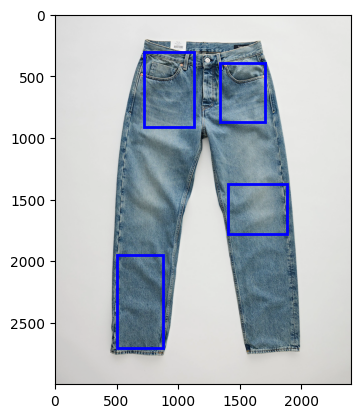

In [10]:
# Load a reference image
ref_image = Image.open("images/jeans/001.jpg").convert("RGB")

# Define ROIs (bounding boxes)
user_drawn_roi = {
    "roi_1": [721, 301, 1129, 913],
    "roi_2": [1341, 393, 1709, 873],
    "roi_3": [1401, 1377, 1885, 1777],
    "roi_4": [501, 1953, 881, 2705],
}

# Learn the ROIs
calibrator.learn_rois(ref_image, user_drawn_roi, reset_learned=True)

# Visualize
plt_draw_rect(ref_image, user_drawn_roi.values())

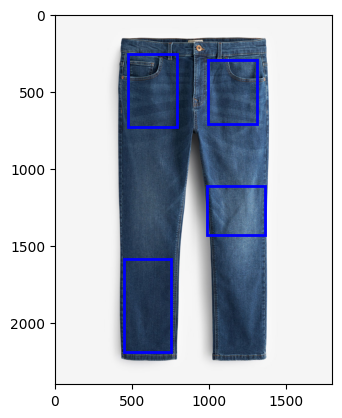

In [11]:
# Load the target image
target_image = Image.open("images/jeans/002.jpg").convert("RGB")

# Predict the ROIs
target_rois = calibrator.predict_rois(target_image)

# Visualize
plt_draw_rect(target_image, target_rois.values())